In [26]:
%matplotlib inline
import os
from subprocess import call

from nistats.first_level_model import FirstLevelModel
from nistats import design_matrix as dm
from bids.layout import BIDSLayout
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import nibabel as nib
import numpy as np

In [12]:
# useful function from nibetaseries 
# https://github.com/HBClab/NiBetaSeries/blob/04a679c164de1316efbac67a289a9ea33d46f64f/src/nibetaseries/interfaces/nistats.py#L278
def _select_confounds(confounds_file, selected_confounds):
    """Process and return selected confounds from the confounds file
    Parameters
    ----------
    confounds_file : str
        File that contains all usable confounds
    selected_confounds : list
        List containing all desired confounds.
        confounds can be listed as regular expressions (e.g., "motion_outlier.*")
    Returns
    -------
    desired_confounds : DataFrame
        contains all desired (processed) confounds.
    """
    import pandas as pd
    import numpy as np
    import re

    confounds_df = pd.read_csv(confounds_file, sep='\t', na_values='n/a')
    # regular expression to capture confounds specified at the command line
    confound_expr = re.compile(r"|".join(selected_confounds))
    expanded_confounds = list(filter(confound_expr.fullmatch, confounds_df.columns))
    imputables = ('framewise_displacement', 'std_dvars', 'dvars', '.*derivative1.*')

    # regular expression to capture all imputable confounds
    impute_expr = re.compile(r"|".join(imputables))
    expanded_imputables = list(filter(impute_expr.fullmatch, expanded_confounds))
    for imputable in expanded_imputables:
        vals = confounds_df[imputable].values
        if not np.isnan(vals[0]):
            continue
        # Impute the mean non-zero, non-NaN value
        confounds_df[imputable][0] = np.nanmean(vals[vals != 0])

    desired_confounds = confounds_df[expanded_confounds]
    # check to see if there are any remaining nans
    if desired_confounds.isna().values.any():
        msg = "The selected confounds contain nans: {conf}".format(conf=expanded_confounds)
        raise ValueError(msg)
    return desired_confounds

def _merge_masks(masks):
    mask_img = nib.load(masks.pop(0))
    add_mask = mask_img.get_fdata().astype(int)
    for counter, mask in enumerate(masks):
        add_mask += nib.load(mask).get_fdata().astype(int)
    half_masks = counter // 2
    bin_mask = np.where(add_mask > half_masks, 1, 0)
    bin_mask_img = nib.Nifti1Image(bin_mask, mask_img.affine, header=mask_img.header)

    return bin_mask_img

In [3]:
# convience function to save figures as eps (with transparency)
def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [4]:
# Hardcoded PATHS
BIDS_PATH = '../..'
FMRIPREP_PATH = '../fmriprep'
# DATABASE_PATH = '/home/jdkent/first_level.sqlite'
# DATABASE_PATH = '/home/jdkent/'
FIRST_LEVEL_RESULTS = './outputs/first_level_res.pkl'
SECOND_LEVEL_RESULTS = './outputs/second_level_res.pkl'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# OUTPUTS
ATLAS_PATH = '../data/overall_response_atlas.nii.gz'
ATLAS_LUT = '../data/overall_response.tsv'

In [5]:
# layout to get the necessary data files
layout = BIDSLayout(BIDS_PATH,
                    derivatives=FMRIPREP_PATH,
                    # database_path=DATABASE_PATH,
                    #reset_database=False
)

In [6]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [7]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [8]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [9]:
ent = layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [76]:
def get_duplicate_columns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if np.all(np.isclose(col, otherCol)):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)


def _fit_first_level(layout, participant, task, confounds, mask, debug_design=False, specific_contrasts=None, high_pass=None):
    preproc = layout.get(subject=participant,
                     suffix='bold',
                     extension='nii.gz',
                     desc='preproc',
                     space='MNI152NLin2009cAsym',
                     task=task)[0]
    preproc_file = preproc.path
    tr = preproc.get_metadata()['RepetitionTime']

    confounds_file = layout.get(subject=participant,
                            suffix='regressors',
                            extension='tsv',
                            desc='confounds',
                            task=task,
                            return_type='file')[0]
    
    event_file = layout.get(subject=participant,
                            suffix='events',
                            extension='tsv',
                            task=task,
                            return_type='file')[0]

    
    events_df = pd.read_csv(event_file, sep='\t')
    print("found files")
    confounds_df = _select_confounds(confounds_file, confounds)
    # drop duplicate columns (e.g., non_steady_state volume may be the same as motion_outlier volume)
    confounds_df.drop(columns=get_duplicate_columns(confounds_df), inplace=True)

    frame_times = np.arange(nib.load(preproc_file).shape[-1]) * tr
    # drift_model is None because I'm assuming user is passing Cosine inputs
    design_matrix = dm.make_first_level_design_matrix(
        frame_times, events_df, drift_model=None, add_regs=confounds_df,
        add_reg_names=confounds_df.columns.to_list())
    
    print("made design matrix")
    
    if debug_design:
        min_mem = False
    else:
        min_mem = True

    # fit the model
    model = FirstLevelModel(t_r=tr,
                            drift_model=None,
                            high_pass=high_pass,
                            smoothing_fwhm=6.0,
                            minimize_memory=min_mem,
                            mask_img=mask)
    
    print("made model")
    model.fit(preproc_file, design_matrices=design_matrix)
    print("fit model")
    trial_types = events_df['trial_type'].unique()
    # generate overall task contrast
    effect_of_interest = np.array([[1 if c == trial_type else 0 for c in design_matrix.columns]
                                   for trial_type in trial_types])

    contrasts = {trial_type: np.array([1 if c == trial_type else 0 for c in design_matrix.columns])
                 for trial_type in trial_types}

    contrasts['overall_resp'] = np.array([[1 if c == trial_type else 0 for c in design_matrix.columns]
                                   for trial_type in trial_types])

    if specific_contrasts:
        for contrast in specific_contrasts:
            contrasts[contrast] = contrast

    print("made contrasts")
    c_maps = {}
    for name, contrast in contrasts.items():
         c_maps[name] = model.compute_contrast(contrast, output_type='all')
    
    print("computed contrasts")

    if debug_design:
        residuals = model.residuals[0]
        return c_maps, design_matrix, residuals, model
    else:
        return c_maps

In [13]:
min_confounds = ["white_matter", "csf", "cosine[0-9]{2}", "framewise_displacement", "non_steady_state_outlier[0-9]{2}", "motion_outlier[0-9]{2}"]
task = 'taskswitch'

no_highpass_confounds = ["white_matter", "csf", "framewise_displacement", "non_steady_state_outlier[0-9]{2}", "motion_outlier[0-9]{2}"]
mask_files = layout.get(suffix='mask',
                        extension='nii.gz',
                        desc='brain',
                        space='MNI152NLin2009cAsym',
                        task=task,
                        subject=good_participants,
                        return_type='file')

mask_img = _merge_masks(mask_files)

In [14]:
plotting.view_img(mask_img, opacity=0.4)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


In [77]:
my_contrasts = ['switch - single', 'repeat - single', 'switch - repeat', '((switch + repeat)/2) - single']
cmaps, dmat, resid, model = _fit_first_level(layout, "GE120005", "taskswitch", min_confounds, mask_img, specific_contrasts=my_contrasts, debug_design=True)

found files
made design matrix
made model


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/first_level_model.py:73: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


fit model
made contrasts
computed contrasts


/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/regression.py:339: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  FutureWarning,


In [78]:
masker = NiftiLabelsMasker(ATLAS_PATH)

In [79]:
resid_rois = masker.fit_transform(resid)

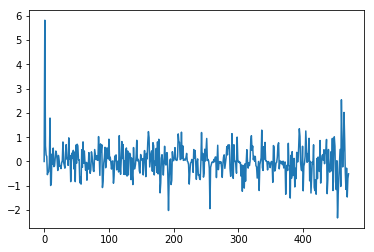

In [80]:
plt.plot(resid_rois[:, 19])

In [81]:
dmat['non_steady_state_outlier00']

0      1.0
2      0.0
4      0.0
6      0.0
8      0.0
10     0.0
12     0.0
14     0.0
16     0.0
18     0.0
20     0.0
22     0.0
24     0.0
26     0.0
28     0.0
30     0.0
32     0.0
34     0.0
36     0.0
38     0.0
40     0.0
42     0.0
44     0.0
46     0.0
48     0.0
50     0.0
52     0.0
54     0.0
56     0.0
58     0.0
      ... 
882    0.0
884    0.0
886    0.0
888    0.0
890    0.0
892    0.0
894    0.0
896    0.0
898    0.0
900    0.0
902    0.0
904    0.0
906    0.0
908    0.0
910    0.0
912    0.0
914    0.0
916    0.0
918    0.0
920    0.0
922    0.0
924    0.0
926    0.0
928    0.0
930    0.0
932    0.0
934    0.0
936    0.0
938    0.0
940    0.0
Name: non_steady_state_outlier00, Length: 471, dtype: float64

In [ ]:
model.compute_contrast()

## Test from another dataset

In [530]:
import nistats

In [531]:
nistats.__version__

'0.0.1b2'

In [139]:
from nistats.datasets import (fetch_openneuro_dataset_index,
                              fetch_openneuro_dataset, select_from_index)
from nistats.first_level_model import FirstLevelModel

_, urls = fetch_openneuro_dataset_index()

exclusion_patterns = ['*group*', '*phenotype*', '*mriqc*',
                      '*parameter_plots*', '*physio_plots*',
                      '*space-fsaverage*', '*space-T1w*',
                      '*dwi*', '*beh*', '*task-bart*',
                      '*task-rest*', '*task-scap*', '*task-task*']
urls = select_from_index(
    urls, exclusion_filters=exclusion_patterns, n_subjects=1)

data_dir, _ = fetch_openneuro_dataset(urls=urls)

In [89]:
from nistats.first_level_model import first_level_models_from_bids
task_label = 'stopsignal'
space_label = 'MNI152NLin2009cAsym'
derivatives_folder = 'derivatives/fmriprep'
models, models_run_imgs, models_events, models_confounds = \
    first_level_models_from_bids(
        data_dir, task_label, space_label, smoothing_fwhm=5.0,
        derivatives_folder=derivatives_folder, minimize_memory=False)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/first_level_model.py:846: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jdkent/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/func/sub-10159_task-stopsignal_bold.json' mode='r' encoding='UTF-8'>
  specs = json.load(open(img_specs[0], 'r'))
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/first_level_model.py:861: UserWarning: SliceTimingRef not found in file /home/jdkent/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/sub-10159/func/sub-10159_task-stopsignal_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  img_specs[0])


In [504]:
model, imgs, events, confounds = (
    models[0], models_run_imgs[0], models_events[0], models_confounds[0])
subject = 'sub-' + model.subject_label
fsl_design_matrix_path = os.path.join(
    data_dir, 'derivatives', 'task', subject, 'stopsignal.feat', 'design.mat')
design_matrix = get_design_from_fslmat(
    fsl_design_matrix_path, column_names=None)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jdkent/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/task/sub-10159/stopsignal.feat/design.mat' mode='r' encoding='UTF-8'>
  # Remove the CWD from sys.path while we load stuff.


In [505]:
design_columns = ['cond_%02d' % i for i in range(len(design_matrix.columns))]
design_columns[0] = 'Go'
design_columns[4] = 'StopSuccess'
design_matrix.columns = design_columns

In [509]:
design_matrix['censor_volume'] = [1] + [0] * (len(design_matrix) - 1)

In [536]:
design_matrix

,Go,cond_01,cond_02,cond_03,StopSuccess,cond_05,cond_06,cond_07,cond_08,cond_09,...,cond_11,cond_12,cond_13,cond_14,cond_15,cond_16,cond_17,cond_18,cond_19,censor_volume
0,-0.230218,0.079032,0.003727,0.002862,-0.050717,-0.000218,-0.017444,-0.001386,-0.006434,0.000134,...,-20.019140,-0.824757,-0.110716,0.047549,-0.040718,-0.218909,0.001071,0.000140,-0.000517,1
1,-0.149587,0.100179,0.006585,-0.006083,-0.050594,-0.000232,-0.019081,-0.001392,-0.006233,0.000135,...,4.395541,0.192955,-0.011924,0.071922,-0.017092,-0.209175,0.001045,0.001173,0.000520,0
2,-0.027468,0.094902,-0.008447,-0.009387,-0.050499,-0.000240,-0.020733,-0.001389,-0.006031,0.000136,...,5.561000,0.185017,0.138909,0.030283,0.002575,-0.115201,0.002018,0.000204,-0.000443,0
3,0.041390,0.084498,-0.012199,-0.005149,-0.050393,-0.000213,-0.022368,-0.001362,-0.005828,0.000137,...,4.338797,0.068376,0.007630,0.012610,0.002256,-0.086907,0.000990,0.000233,-0.000404,0
4,0.142013,0.094844,-0.018754,-0.007607,-0.050245,-0.000163,-0.023971,-0.001324,-0.005625,0.000137,...,-0.201748,0.011911,-0.101468,0.022854,0.000969,-0.088237,0.000960,0.000261,-0.000365,0
5,0.230557,0.071567,-0.027421,-0.001885,-0.050039,-0.000103,-0.025534,-0.001279,-0.005423,0.000138,...,0.257153,0.018639,-0.022754,0.018078,0.002708,-0.049299,0.000928,0.000287,-0.000325,0
6,0.283743,0.037777,-0.022531,0.009960,-0.049772,-0.000041,-0.027050,-0.001192,-0.005220,0.000137,...,2.326362,0.051584,0.095920,-0.006743,0.021472,0.022906,-0.001105,0.000311,-0.000284,0
7,0.304174,-0.026485,-0.007510,0.002372,-0.049442,0.000056,-0.028442,0.004657,-0.005020,0.002743,...,-1.115558,-0.002205,-0.028409,-0.020603,-0.006751,0.002340,-0.001139,0.000334,-0.000242,0
8,0.228632,-0.142845,-0.017795,-0.006704,-0.048982,0.000166,-0.018264,0.069621,0.000395,0.020269,...,-3.029231,-0.055810,0.056259,-0.039501,0.009048,0.083990,-0.001174,0.000356,-0.000200,0
9,0.017098,-0.200636,-0.020926,0.002036,-0.048433,0.004640,0.110297,0.096766,0.035630,0.020864,...,-2.745096,-0.060161,0.003970,-0.010443,-0.007129,0.045945,-0.001210,0.000376,-0.000157,0


In [535]:
design_matrix

,Go,cond_01,cond_02,cond_03,StopSuccess,cond_05,cond_06,cond_07,cond_08,cond_09,...,cond_11,cond_12,cond_13,cond_14,cond_15,cond_16,cond_17,cond_18,cond_19,censor_volume
0,-0.230218,0.079032,0.003727,0.002862,-0.050717,-0.000218,-0.017444,-0.001386,-0.006434,0.000134,...,-20.019140,-0.824757,-0.110716,0.047549,-0.040718,-0.218909,0.001071,0.000140,-0.000517,1
1,-0.149587,0.100179,0.006585,-0.006083,-0.050594,-0.000232,-0.019081,-0.001392,-0.006233,0.000135,...,4.395541,0.192955,-0.011924,0.071922,-0.017092,-0.209175,0.001045,0.001173,0.000520,0
2,-0.027468,0.094902,-0.008447,-0.009387,-0.050499,-0.000240,-0.020733,-0.001389,-0.006031,0.000136,...,5.561000,0.185017,0.138909,0.030283,0.002575,-0.115201,0.002018,0.000204,-0.000443,0
3,0.041390,0.084498,-0.012199,-0.005149,-0.050393,-0.000213,-0.022368,-0.001362,-0.005828,0.000137,...,4.338797,0.068376,0.007630,0.012610,0.002256,-0.086907,0.000990,0.000233,-0.000404,0
4,0.142013,0.094844,-0.018754,-0.007607,-0.050245,-0.000163,-0.023971,-0.001324,-0.005625,0.000137,...,-0.201748,0.011911,-0.101468,0.022854,0.000969,-0.088237,0.000960,0.000261,-0.000365,0
5,0.230557,0.071567,-0.027421,-0.001885,-0.050039,-0.000103,-0.025534,-0.001279,-0.005423,0.000138,...,0.257153,0.018639,-0.022754,0.018078,0.002708,-0.049299,0.000928,0.000287,-0.000325,0
6,0.283743,0.037777,-0.022531,0.009960,-0.049772,-0.000041,-0.027050,-0.001192,-0.005220,0.000137,...,2.326362,0.051584,0.095920,-0.006743,0.021472,0.022906,-0.001105,0.000311,-0.000284,0
7,0.304174,-0.026485,-0.007510,0.002372,-0.049442,0.000056,-0.028442,0.004657,-0.005020,0.002743,...,-1.115558,-0.002205,-0.028409,-0.020603,-0.006751,0.002340,-0.001139,0.000334,-0.000242,0
8,0.228632,-0.142845,-0.017795,-0.006704,-0.048982,0.000166,-0.018264,0.069621,0.000395,0.020269,...,-3.029231,-0.055810,0.056259,-0.039501,0.009048,0.083990,-0.001174,0.000356,-0.000200,0
9,0.017098,-0.200636,-0.020926,0.002036,-0.048433,0.004640,0.110297,0.096766,0.035630,0.020864,...,-2.745096,-0.060161,0.003970,-0.010443,-0.007129,0.045945,-0.001210,0.000376,-0.000157,0


In [517]:
# add a constant value in the first volume
nii_img = nib.load(imgs[0])
middle_voxel = tuple(np.array(nii_img.shape[:-1]) // 2)
nii_data = nii_img.get_fdata()
nii_data[...,0] += 1000
new_img = nib.Nifti1Image(nii_data, affine=nii_img.affine, header=nii_img.header)

In [544]:
my_model = FirstLevelModel(t_r=1, noise_model='ols', minimize_memory=False)
my_model.fit(new_img, design_matrices=design_matrix)

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        high_pass=0.01, hrf_model='glover', mask_img=None,
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=False, n_jobs=1, noise_model='ols',
        signal_scaling=False, slice_time_ref=0.0, smoothing_fwhm=None,
        standardize=False, subject_label=None, t_r=1, target_affine=None,
        target_shape=None, verbose=0)

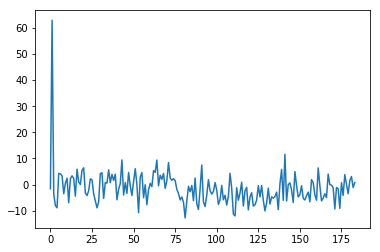

In [545]:
plt.plot(resid.get_fdata()[middle_voxel])

In [521]:
linr4 = LinearRegression()

In [526]:
linr4.fit(design_matrix.values, nii_data[middle_voxel])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [528]:
linresid = nii_data[middle_voxel] - np.sum(design_matrix.values * linr4.coef_ + linr2.intercept_, axis=1)

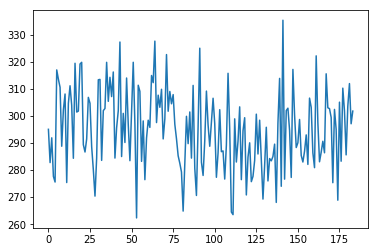

In [529]:
plt.plot(linresid)

In [478]:
x = np.random.random((100, 1))
y = np.random.random(100)

In [479]:
x.shape

(100, 1)

In [480]:
from sklearn.linear_model import LinearRegression

In [481]:
linr = LinearRegression()

In [482]:
linr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [483]:
linr.coef_

array([0.1217759])

In [484]:
linr.intercept_

0.4034396983154981

In [485]:
x_pred = x * linr.coef_ + linr.intercept_

In [486]:
resid = y - x_pred.flatten()

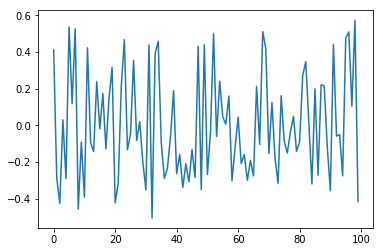

In [487]:
plt.plot(resid)

In [488]:
np.array([[[y]]]).shape


(1, 1, 1, 100)

In [489]:
design_matrix = pd.DataFrame(x)
y_img = nib.Nifti1Image(np.array([[[y]]]), np.eye(4))
mask_img = nib.Nifti1Image(np.array([[[1]]]), np.eye(4))
my_model = FirstLevelModel(t_r=1, minimize_memory=False, mask_img=mask_img, high_pass=None)

my_model.fit(y_img, design_matrices=design_matrix)

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        high_pass=None, hrf_model='glover',
        mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fe6109c97d0>,
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=False, n_jobs=1, noise_model='ar1',
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
        standardize=False, subject_label=None, t_r=1, target_affine=None,
        target_shape=None, verbose=0)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nistats/regression.py:339: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  FutureWarning,


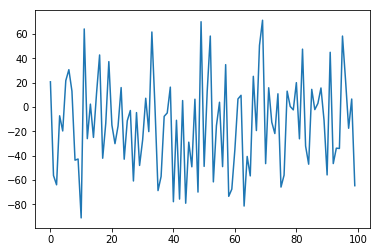

In [490]:
plt.plot(my_model.residuals[0].get_fdata().flatten())

In [491]:
y[0] += 10000

In [492]:
x_outlier = np.hstack([x, np.array([[1] + [0] * (len(x) - 1)]).T])

In [493]:
x_outlier.shape

(100, 2)

In [494]:
linr2 = LinearRegression()

In [495]:
linr2.fit(x_outlier, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [496]:
resid2 = y.flatten() - np.sum(x_outlier * linr2.coef_ + linr2.intercept_, axis=1)

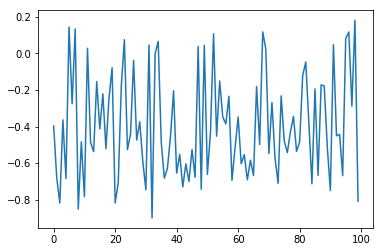

In [497]:
plt.plot(resid2)

In [498]:
y_img = nib.Nifti1Image(np.array([[[y]]]), np.eye(4))
design_matrix = pd.DataFrame(x_outlier)

In [499]:
my_model.fit(y_img, design_matrices=design_matrix)

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        high_pass=None, hrf_model='glover',
        mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fe6109c97d0>,
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=False, n_jobs=1, noise_model='ar1',
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
        standardize=False, subject_label=None, t_r=1, target_affine=None,
        target_shape=None, verbose=0)

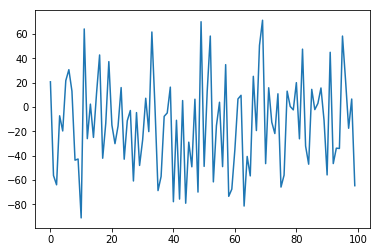

In [500]:
plt.plot(my_model.residuals[0].get_fdata().flatten())